#### **Langchain Expression Language (LCEL)**

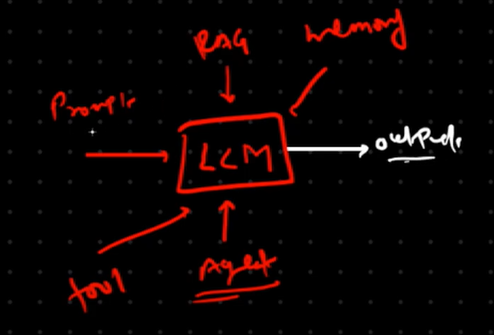

We have LLM (Large language Model), to generate the output in a optimized or better way. We passed the prompt, RAG, agents (tools), memory to get the better output.

In [50]:
# Importing the required libraries
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableParallel,RunnableLambda
from langchain_chroma import Chroma
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from operator import itemgetter

load_dotenv()

True

In [2]:
os.chdir("e:\\Programming\\Projects\\LLM\\Langchain for everbody")

In [3]:
# Setting the environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [4]:
# getting the llm model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0,max_retries=2)

##### **Chains**

**Simple Chain (Old Method)**

In [5]:
# setting the PromptTemplate
prompt = "I am learning {input}, Give me the top 5 topics, which I should focus while learning."
prompt_template = PromptTemplate(template=prompt,input_variables=['input'])
llm_chain = LLMChain(prompt=prompt_template,llm=llm)
response = llm_chain.run({"input":"Data Science"})
print(response)

C:\Users\admin\AppData\Local\Temp\ipykernel_38124\159092801.py:4: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(prompt=prompt_template,llm=llm)
C:\Users\admin\AppData\Local\Temp\ipykernel_38124\159092801.py:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm_chain.run({"input":"Data Science"})


As a Data Science learner, focusing on the right topics can help you build a strong foundation and increase your job prospects. Here are the top 5 topics to focus on:

**1. Python Programming**: Python is the most widely used language in Data Science. It has extensive libraries like NumPy, pandas, and scikit-learn, which make data manipulation, analysis, and modeling easier. Mastering Python will help you to:
	* Work with data structures and files
	* Perform data cleaning, preprocessing, and visualization
	* Implement machine learning algorithms

**2. Machine Learning**: Machine Learning is a crucial aspect of Data Science. It involves training models to make predictions or decisions based on data. Focus on:
	* Supervised learning (regression, classification)
	* Unsupervised learning (clustering, dimensionality reduction)
	* Model evaluation and selection
	* Popular algorithms like linear regression, decision trees, random forests, and neural networks

**3. Data Preprocessing and Visua

**Simple Chain (New Method)**

we are using .invoke() method directly on chain because every thing we are using has the .invoke() method in their class implementation.

In [6]:
new_chain = prompt_template | llm | StrOutputParser()
response = new_chain.invoke({"input":'Data Science'})
print(response)

As a Data Science learner, focusing on the right topics can help you build a strong foundation and increase your job prospects. Here are the top 5 topics to focus on:

**1. Python Programming**: Python is the most widely used language in Data Science. It has extensive libraries like NumPy, pandas, and scikit-learn, which make data manipulation, analysis, and modeling easier. Mastering Python will help you to:
	* Work with data structures and files
	* Perform data cleaning, preprocessing, and visualization
	* Implement machine learning algorithms

**2. Machine Learning**: Machine Learning is a crucial aspect of Data Science. It involves training models to make predictions or decisions based on data. Focus on:
	* Supervised learning (regression, classification)
	* Unsupervised learning (clustering, dimensionality reduction)
	* Model evaluation and selection
	* Popular algorithms like linear regression, decision trees, random forests, and neural networks

**3. Data Preprocessing and Visua

##### **Runnables**

In LangChain, custom runnables are user-defined components that implement the Runnable interface, allowing developers to define bespoke processing logic tailored to specific application needs. These custom runnables can be seamlessly integrated into LangChain workflows, enabling complex and flexible data processing pipelines.

RunnablePassthough

In [7]:
chain = RunnablePassthrough()
chain.invoke("Hi using the RunnablePassthrough")

'Hi using the RunnablePassthrough'

In [17]:
chain = RunnablePassthrough() | RunnablePassthrough() | RunnablePassthrough()
chain.invoke("Hi using the RunnablePassthough")

'Hi using the RunnablePassthough'

RunnableLambda

In [18]:
def RunnableUpper(string:str)->str:
    return string.upper()

chain = RunnablePassthrough() | RunnableLambda(RunnableUpper)
chain.invoke("Hi, hrishikesh kothawade here!")

'HI, HRISHIKESH KOTHAWADE HERE!'

RunnableParallel

In [20]:
chain = RunnableParallel({'x':RunnablePassthrough() ,'y':RunnablePassthrough()})
chain.invoke("Hrishikesh")

{'x': 'Hrishikesh', 'y': 'Hrishikesh'}

In [21]:
chain = RunnableParallel({'x':RunnablePassthrough() | RunnableLambda(RunnableUpper) ,'y':RunnablePassthrough()})
chain.invoke("Hrishikesh")

{'x': 'HRISHIKESH', 'y': 'Hrishikesh'}

Complex Examples

In [24]:
def fetch_website(input: dict):
    output = input.get('Youtube','Not Found')
    return output
    
chain = RunnableParallel({'Youtube':RunnablePassthrough() | RunnableLambda(fetch_website),'Blog':lambda z:z['flog']})
chain.invoke({'Youtube':"AI Mind",'flog':"Hrishi's youtube"})

{'Youtube': 'AI Mind', 'Blog': "Hrishi's youtube"}

In [25]:
chain.invoke({'Youtube':"AI Mind",'flog':"Hrishi's youtube",'Website':'Hrishikesh Kothawade'})

{'Youtube': 'AI Mind', 'Blog': "Hrishi's youtube"}

Rag Pipeline using LCEL

In [26]:
# load the text from the .txt file
text_loader = TextLoader(file_path='article_data_science.txt')
documents = text_loader.load()

# Chunking of the documents 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=30,length_function=len)
documents = text_splitter.split_documents(documents=documents)
# doc_string = [document.page_content for document in documents]


# Loading of the embeddings using huggingface
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Initialize the vector database
chromadb = Chroma.from_documents(documents=documents,embedding=embeddings)
retriever = chromadb.as_retriever(search_kwargs={'k':4})

c:\Users\admin\anaconda3\envs\env_langchain_tutorial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
# Setting the PromptTemplate
prompt = """
Answer the following questions based on the following context:
{context}

Question : {question}
"""
prompt_template = PromptTemplate.from_template(template=prompt)

In [46]:
# Creating the chain of RAG using LCEL
retrieval_chain = (
    {"context":retriever, "question":RunnablePassthrough()}
    | prompt_template
    | llm
    | StrOutputParser()
)

In [47]:
question = "Evolution of Data Science in 5 points"
response = retrieval_chain.invoke(question)
print(response)

Based on the provided context, here are 5 points on the evolution of data science:

1. **The Foundation: Statistics**: The evolution of data science begins with statistics, which provides the foundational tools and concepts used in data analysis today.
2. **Providing Foundational Tools**: Data science is built on foundational tools and concepts, such as statistical methods, that are used to analyze and interpret data.
3. **Integration of Areas**: The future of data science will likely involve deeper integration of various areas, including statistics, machine learning, and other disciplines.
4. **Enhanced by New Technologies**: The evolution of data science will be enhanced by new technologies, such as advanced computational power and algorithms, that enable more efficient and effective data analysis.
5. **Generative AI: The Latest Advancement**: The latest advancement in data science is Generative AI, which focuses on creating new content, such as images, videos, and text, using machin

In [32]:
response = retrieval_chain.abatch([
    'Evolution of Data science in 5 points',
    'What is generative ai'
])

In [34]:
for s in retrieval_chain.stream("Evolution of Data Science"):
    print(s,end=" ")

 The  evolution  of  data  science  is  described  in  the  provided  context  as  follows :

 1 .  ** The  Foundation :  Statistics **  -  This  is  mentioned  as  the  starting  point  of  data  science ,  indicating  that  statistics  played  a  crucial  role  in  its  development .

 2 .  ** Emer gence  of  Machine  Learning **  -  In  the  mid - 20 th  century ,  with  advancements  in  computer  science ,  machine  learning  emerged .  This  marked  a  significant  step  in  the  evolution  of  data  science ,  as  machine  learning  enables  systems  to  learn  from  data  without  being  explicitly  programmed .

 3 .  ** Integration  and  Enhancement **  -  The  future  of  data  science  is  predicted  to  involve  a  deeper  integration  of  various  areas ,  with  enhancements  likely  coming  from  technological  advancements  and  interdisciplinary  approaches .

 4 .  ** Gener ative  AI **  -  Represent ing  the  latest  advancement  in  data  science ,  Gener ative  AI 

In [35]:
# Setting the PromptTemplate
prompt = """
Answer the following questions based on the following context:
{context}

Question : {question}
Answer the question in language : {language}
"""
prompt_template = PromptTemplate.from_template(template=prompt)

In [36]:
retrieval_chain = (
    RunnableParallel({
        "context": itemgetter("question") | retriever.map(),
        "question": itemgetter("question"),
        "language": itemgetter("language")
    })
    | prompt_template
    | llm
    | StrOutputParser()
)

# Invoke the chain with proper input format
result = retrieval_chain.invoke({
    "question": "evolution of Data science",
    "language": "Hinglish"
})


In [87]:
print(result)

Data science की evolution की बात करें तो, यह एक बहुत ही रोचक और तेजी से विकसित हो रहा क्षेत्र है। 

पहले, data science में मुख्य रूप से statistical techniques और machine learning algorithms का उपयोग किया जाता था, लेकिन अब यह क्षेत्र बहुत व्यापक हो गया है और इसमें कई नए techniques और tools शामिल हो गए हैं।

एक महत्वपूर्ण मील का पत्थर था 2017 में, जब transformer architecture की शुरुआत हुई, जिसने natural language processing में एक नए युग की शुरुआत की। इसके अलावा, deep learning के क्षेत्र में भी बहुत प्रगति हुई है, जिसमें neural networks और convolutional neural networks (CNNs) शामिल हैं।

आजकल, data science में कई नए applications और techniques हैं, जैसे कि computer vision, natural language processing, और recommender systems। इसके अलावा, data science का उपयोग अब विभिन्न क्षेत्रों में किया जा रहा है, जैसे कि healthcare, finance, और marketing।

इस प्रकार, data science की evolution एक बहुत ही रोचक और तेजी से विकसित हो रहा क्षेत्र है, जिसमें नए techniques और tools का निरंतर विकास हो रहा है। 

क

In [15]:
prompt = """
Answer the following input based on the following context:
{context}

Question : {input}
"""
prompt_template = PromptTemplate.from_template(template=prompt)

In [16]:
document_chain = create_stuff_documents_chain(llm,prompt_template)
document_chain

RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
| PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template='\nAnswer the following input based on the following context:\n{context}\n\nQuestion : {input}\n')
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000240D387FD00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000240D38B0910>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))
| StrOutputParser(), kwargs={}, config={'run_name': 'stuff_documents_chain'}, config_factories=[])

In [49]:
question = "Key milestones of Data Science"
docs = retriever.get_relevant_documents(question)
print(docs)
response = document_chain.invoke({"context":docs,"input":question})
print(response)

C:\Users\admin\AppData\Local\Temp\ipykernel_38124\3991745615.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


[Document(metadata={'source': 'article_data_science.txt'}, page_content='The future of data science will likely involve deeper integration of these areas, enhanced by'), Document(metadata={'source': 'article_data_science.txt'}, page_content='providing the foundational tools and concepts used in data analysis today, such as:'), Document(metadata={'source': 'article_data_science.txt'}, page_content='The Evolution of Data Science\n1. The Foundation: Statistics'), Document(metadata={'source': 'article_data_science.txt'}, page_content='Key milestones:')]
Based on the context provided, the key milestones of Data Science include:

1. The Foundation: Statistics 

This suggests that statistics is a fundamental aspect and a key milestone in the evolution and development of Data Science.


In [51]:
# create_retrieval_chain is used to pass the retriever as runnable. 
retrieval_chain = create_retrieval_chain(retriever=retriever,combine_docs_chain=document_chain)
retrieval_chain

RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableLambda(lambda x: x['input'])
           | VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000240D79240D0>, search_kwargs={'k': 4}), kwargs={}, config={'run_name': 'retrieve_documents'}, config_factories=[])
})
| RunnableAssign(mapper={
    answer: RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
              context: RunnableLambda(format_docs)
            }), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
            | PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template='\nAnswer the following input based on the following context:\n{context}\n\nQuestion : {input}\n')
            | ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000240D387FD00>, async_client=<groq.resources.chat.completions.AsyncCompletions

In [55]:
response = retrieval_chain.invoke({"input":question})
print(response['answer'])

Based on the context provided, the key milestones of Data Science include:

1. The Foundation: Statistics 

This suggests that statistics is a fundamental aspect and a key milestone in the evolution and development of Data Science.
